In [1]:
# Импорт библиотек
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from shutil import copyfile
from torchvision import transforms
import fastai
from fastai.vision.all import *
from sklearn.model_selection import ShuffleSplit

In [2]:
# Обозначим размеры изображений
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

In [3]:
# Создадим переменную с директорией тестовых изображений
PATH_TRAIN = '/content/drive/MyDrive/datasets/train'

In [4]:
# Загрузим csv-файл
df = pd.read_csv('/content/drive/MyDrive/datasets/train_df.csv')
df.head()

,SOPInstanceUID,Target,MultiImageType,ImageType,ImageType1,InstanceCreationDate,InstanceCreationTime,SOPClassUID,StudyDate,SeriesDate,...,WindowWidth,ImageType2,KVP,DistanceSourceToDetector,DistanceSourceToPatient,ExposureTime,XRayTubeCurrent,AcquisitionNumber,ImageType3,image_path
0,1.2.826.0.1.3680043.8.498.10025629581362719970278200333618114258,0,1.0,ORIGINAL,PRIMARY,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,./images/train/1.2.826.0.1.3680043.8.498.10025629581362719970278200333618114258-c.png
1,1.2.826.0.1.3680043.8.498.10036150326276641158002573300029848125,15,1.0,ORIGINAL,PRIMARY,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,./images/train/1.2.826.0.1.3680043.8.498.10036150326276641158002573300029848125-c.png
2,1.2.826.0.1.3680043.8.498.10038426859954986240523417641213777162,12,1.0,ORIGINAL,PRIMARY,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,./images/train/1.2.826.0.1.3680043.8.498.10038426859954986240523417641213777162-c.png
3,1.2.826.0.1.3680043.8.498.10050991192143676483577217922037244257,14,NaN,NaN,NaN,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,./images/train/1.2.826.0.1.3680043.8.498.10050991192143676483577217922037244257-c.png
4,1.2.826.0.1.3680043.8.498.10053309524595490852815579052225336016,3,1.0,ORIGINAL,PRIMARY,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,./images/train/1.2.826.0.1.3680043.8.498.10053309524595490852815579052225336016-c.png


In [5]:
# Оставим в таблице столбцы с названием файла и его лейблом и переименуем столбец с названием
df = df.loc[:, ['SOPInstanceUID', 'Target']]
df = df.rename(columns={'SOPInstanceUID': 'Filename'})
df.head()

,Filename,Target
0,1.2.826.0.1.3680043.8.498.10025629581362719970278200333618114258,0
1,1.2.826.0.1.3680043.8.498.10036150326276641158002573300029848125,15
2,1.2.826.0.1.3680043.8.498.10038426859954986240523417641213777162,12
3,1.2.826.0.1.3680043.8.498.10050991192143676483577217922037244257,14
4,1.2.826.0.1.3680043.8.498.10053309524595490852815579052225336016,3


In [6]:
# Согласно условию имеем следующие обозначения таргетов
Abdomen = 0
Ankle = 1
Cervical_Spine = 2
Chest = 3
Clavicles = 4
Elbow = 5
Feet = 6
Finger = 7
Forearm = 8
Hand = 9
Hip = 10
Knee = 11
Lower_Leg = 12
Lumbar_Spine = 13
Others = 14
Pelvis = 15
Shoulder = 16
Sinus = 17
Skull = 18
Thigh = 19
Thoracic_Spine = 20
Wrist = 21

In [7]:
# Посмотрим на уникальные значения таргетов и их количество
value_counts = df['Target'].value_counts()
value_counts

3            724
14           120
11           102
0             80
2             77
6             70
15            67
21            63
13 20         45
9 21          42
1             41
16            40
13            39
9             31
17            23
5             23
12            19
10            19
7             15
20            15
8             12
0 3           11
18            10
4              9
19             7
1 6            7
1 11 12        5
10 19          4
2 13 20        3
5 8            2
10 11 19       2
15 19          2
2 20           1
3 7            1
1 12           1
7 9            1
3 6            1
0 15           1
3 15           1
11 12          1
8 16           1
Name: Target, dtype: int64

Как видим, много снимков одновременно относятся к нескольким классам одновременно.


In [8]:
# Уберем лишние пробелы в таргете
df['Target'] = df['Target'].apply(lambda x: x.strip())

In [9]:
# Добавим к названиям изображений наименование формата, чтобы генератор изображений смог соотнести изображения с их названиями
df['Filename'] = df['Filename'].apply(lambda x: f'{x}-c.png')
df

,Filename,Target
0,1.2.826.0.1.3680043.8.498.10025629581362719970278200333618114258-c.png,0
1,1.2.826.0.1.3680043.8.498.10036150326276641158002573300029848125-c.png,15
2,1.2.826.0.1.3680043.8.498.10038426859954986240523417641213777162-c.png,12
3,1.2.826.0.1.3680043.8.498.10050991192143676483577217922037244257-c.png,14
4,1.2.826.0.1.3680043.8.498.10053309524595490852815579052225336016-c.png,3
...,...,...
1733,1.2.826.0.1.3680043.8.498.99711016467406172920578985719244800351-c.png,14
1734,1.2.826.0.1.3680043.8.498.99727280485333900933067489723088200708-c.png,11
1735,1.2.826.0.1.3680043.8.498.99935008698914755885142961280499046059-c.png,3
1736,1.2.826.0.1.3680043.8.498.99969671777553755311455387279891445345-c.png,2


In [10]:
# Применим сплит к каждому таргету
df['Target'] = df['Target'].apply(lambda x: x.split(' '))

In [11]:
# Посмотрим, что получилось
df['Target'].value_counts()

[3]             724
[14]            120
[11]            102
[0]              80
[2]              77
[6]              70
[15]             67
[21]             63
[13, 20]         45
[9, 21]          42
[1]              41
[16]             40
[13]             39
[9]              31
[17]             23
[5]              23
[12]             19
[10]             19
[7]              15
[20]             15
[8]              12
[0, 3]           11
[18]             10
[4]               9
[19]              7
[1, 6]            7
[1, 11, 12]       5
[10, 19]          4
[2, 13, 20]       3
[5, 8]            2
[10, 11, 19]      2
[15, 19]          2
[2, 20]           1
[3, 7]            1
[1, 12]           1
[7, 9]            1
[3, 6]            1
[0, 15]           1
[3, 15]           1
[11, 12]          1
[8, 16]           1
Name: Target, dtype: int64

In [12]:
# Напишем функцию для замены числовых лейблов на названия органов
def replace_dict(key_list):
    dict_of_labels = {'0': 'Abdomen',
                      '1': 'Ankle',
                      '2': 'Cervical_Spine',
                      '3': 'Chest',
                      '4': 'Clavicles',
                      '5': 'Elbow',
                      '6': 'Feet',
                      '7': 'Finger',
                      '8': 'Forearm',
                      '9': 'Hand',
                      '10': 'Hip',
                      '11': 'Knee',
                      '12': 'Lower_Leg',
                      '13': 'Lumbar_Spine',
                      '14': 'Others',
                      '15': 'Pelvis',
                      '16': 'Shoulder',
                      '17': 'Sinus',
                      '18': 'Skull',
                      '19': 'Thigh',
                      '20': 'Thoracic_Spine',
                      '21': 'Wrist'}
    for i in range(len(key_list)):
        for k, v in dict_of_labels.items():
            if key_list[i] == k:
                key_list[i] = v
    return ', '.join(key_list)

In [13]:
# Применим функцию к каждой строке
df['Target'] = df['Target'].apply(replace_dict)

In [14]:
# Посмотрим, что получилось
df['Target'].value_counts()

Chest                                           724
Others                                          120
Knee                                            102
Abdomen                                          80
Cervical_Spine                                   77
Feet                                             70
Pelvis                                           67
Wrist                                            63
Lumbar_Spine, Thoracic_Spine                     45
Hand, Wrist                                      42
Ankle                                            41
Shoulder                                         40
Lumbar_Spine                                     39
Hand                                             31
Sinus                                            23
Elbow                                            23
Lower_Leg                                        19
Hip                                              19
Finger                                           15
Thoracic_Spi

In [15]:
# Разобъем датасет на обучающую и валидационную, а также создадим генераторы с индексами для обеих подвыборок
X = df
y = df['Target']
sss = ShuffleSplit(n_splits=1, test_size=.2, random_state=12345)
train_idx, val_idx = next(sss.split(X, y))

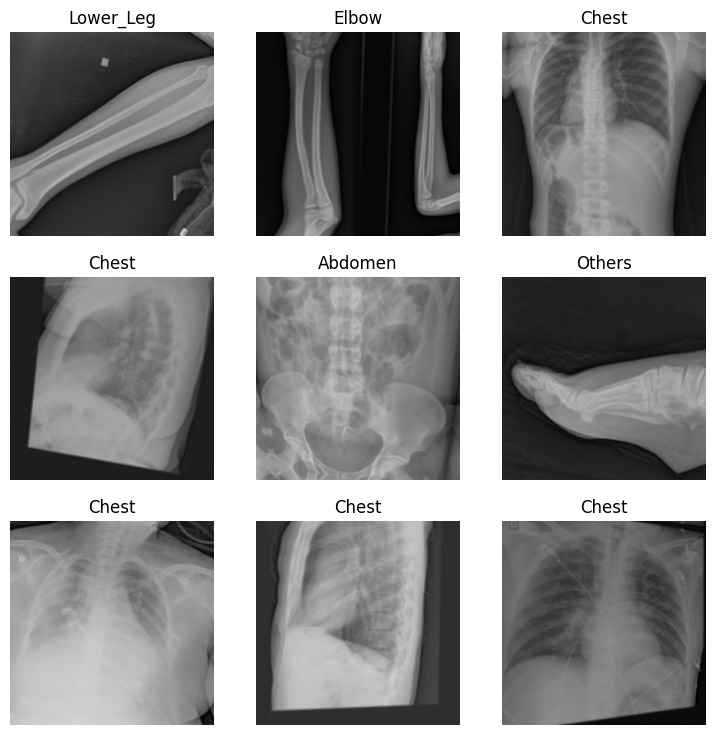

In [16]:
# Создадим столбец для определения отнесения элемента к обучающей или валидационной выборке
df['is_valid'] = False
df.loc[val_idx, 'is_valid'] = True
# Воспользуемся ImageDataLoaders для обработки изображений
dls = ImageDataLoaders.from_df(df,
                               fn_col = 'Filename',
                               label_col = 'Target',
                               label_delim = ', ',
                               valid_col='is_valid',
                               path = PATH_TRAIN,
                               item_tfms=Resize(224),
                               batch_tfms=aug_transforms(size=224),
                               model_dir='/content/drive/MyDrive')
# Посмотрим на изображения
dls.show_batch()

In [17]:
# Для обучения модели возьмем 4 показателя f1 с разным вычислением средних значений и accuracy
f1_macro = F1ScoreMulti(thresh=0.5, average='macro')
f1_samples = F1ScoreMulti(thresh=0.5, average='samples')
f1_micro = F1ScoreMulti(thresh=0.5, average='micro')
f1_weighted = F1ScoreMulti(thresh=0.5, average='weighted')
# В качестве модели будем использовать resnet50
learn = vision_learner(dls, resnet50,
                    metrics=[partial(accuracy_multi, thresh=0.5), f1_macro, f1_samples, f1_micro, f1_weighted])

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 164MB/s]


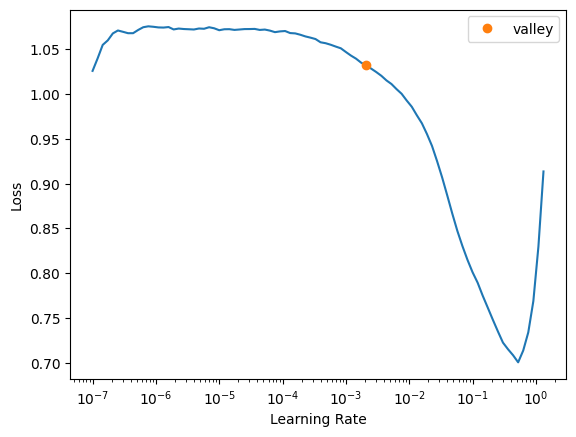

In [18]:
# Найдем оптимальное значение learning rate
lr = learn.lr_find()

In [19]:
# Обучим модель на 50 эпохах
learn.fine_tune(50, lr[0])

epoch,train_loss,valid_loss,accuracy_multi,f1_score,f1_score,f1_score,f1_score,time
0,0.986321,0.619454,0.652821,0.163789,0.190938,0.189140,0.443670,02:53


epoch,train_loss,valid_loss,accuracy_multi,f1_score,f1_score,f1_score,f1_score,time
0,0.850933,0.684029,0.602795,0.154081,0.173150,0.167534,0.416635,00:19
1,0.833792,0.634795,0.648642,0.162388,0.194151,0.188292,0.431386,00:20
2,0.808929,0.587708,0.697362,0.181152,0.237755,0.224305,0.482501,00:20
3,0.782386,0.572835,0.706505,0.200117,0.256271,0.237530,0.502957,00:19
4,0.751122,0.515172,0.766327,0.219981,0.308645,0.276002,0.518030,00:21
5,0.712615,0.479515,0.812435,0.256797,0.377417,0.327715,0.556500,00:19
6,0.667863,0.432536,0.868600,0.308673,0.473317,0.410317,0.607544,00:20
7,0.607523,0.330640,0.941745,0.417852,0.655686,0.598198,0.684355,00:20
8,0.535462,0.261544,0.971787,0.535202,0.776245,0.746479,0.754252,00:19
9,0.454285,0.187070,0.978710,0.502613,0.777874,0.789677,0.770682,00:21


In [24]:
# Сохраним модель
learn.export('/content/drive/MyDrive/my_model.pth')

In [25]:
from fastai.vision.learner import load_learner

# Загрузим модель
learn = load_learner('/content/drive/MyDrive/my_model.pth')

In [26]:
# Функция для проверки изображений
from google.colab import files
import io

def check_image():
    uploaded = files.upload()

    for filename, content in uploaded.items():
        img = Image.open(io.BytesIO(content))
        img = img.resize((224, 224))
        display(img)
        pred_probs = learn.predict(img)[2]
        top_classes = pred_probs.topk(2)
        for class_idx, prob in zip(top_classes.indices, top_classes.values):
            class_name = learn.dls.vocab[class_idx]
            print(f"Class: {class_name}; Probability: {prob}")

Saving 1.2.826.0.1.3680043.8.498.11563478688840426923610038771798550378-c.png to 1.2.826.0.1.3680043.8.498.11563478688840426923610038771798550378-c.png


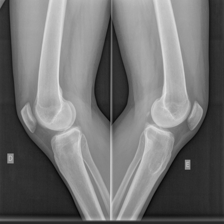

Class: Knee; Probability: 0.9980156421661377
Class: Lower_Leg; Probability: 0.006732886657118797


In [27]:
check_image()